### 1. Importing libraries

In [25]:
#importing the neccessary libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input

# Set options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
#seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
#connecting with the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Load data

In [4]:
#reading data
# #Change path to your images and csv files path
# train_data = pd.read_csv('Runmila_AI_Institute_Challenge/Train.csv')
# test_data = pd.read_csv('Runmila_AI_Institute_Challenge/Test.csv')
# train_path = 'Runmila_AI_Institute_Challenge/train_small/'
# test_path = 'Runmila_AI_Institute_Challenge/test_small/'


#reading the csv and data images from drive
train_data = pd.read_csv('/content/drive/MyDrive/zindi_Tuberculosis_Classification/Train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/zindi_Tuberculosis_Classification/Test.csv')
train_path = '/content/drive/MyDrive/zindi_Tuberculosis_Classification/train_small/'
test_path = '/content/drive/MyDrive/zindi_Tuberculosis_Classification/test_small/'

In [5]:
#creating train and test dataframe
#we will create dataframes and use keras Image data preprocessing function: flow_from_dataframe

# creating the train dataframe
train_names = train_data.ID.values        #getting the ID column
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels} # creating a dictionary that contain the filepath, label, imagename and appending jpg
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Normal') #encoding the categorical variable

# creating the test dataframe
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']

In [6]:
train.head()

,filepath,LABEL,ID
0,/content/drive/MyDrive/zindi_Tuberculosis_Classification/train_small/VTYNBFTO.png,Positive,VTYNBFTO
1,/content/drive/MyDrive/zindi_Tuberculosis_Classification/train_small/GVVXXDOZ.png,Normal,GVVXXDOZ
2,/content/drive/MyDrive/zindi_Tuberculosis_Classification/train_small/PMRSQLXN.png,Normal,PMRSQLXN
3,/content/drive/MyDrive/zindi_Tuberculosis_Classification/train_small/JXISWDUU.png,Positive,JXISWDUU
4,/content/drive/MyDrive/zindi_Tuberculosis_Classification/train_small/JVWMAACC.png,Positive,JVWMAACC


In [7]:
test.head()

,filepath,ID
0,/content/drive/MyDrive/zindi_Tuberculosis_Classification/test_small/GTWSHFYQ.png,GTWSHFYQ
1,/content/drive/MyDrive/zindi_Tuberculosis_Classification/test_small/QTFSSMGD.png,QTFSSMGD
2,/content/drive/MyDrive/zindi_Tuberculosis_Classification/test_small/TBLBHSYT.png,TBLBHSYT
3,/content/drive/MyDrive/zindi_Tuberculosis_Classification/test_small/ZKETEOFG.png,ZKETEOFG
4,/content/drive/MyDrive/zindi_Tuberculosis_Classification/test_small/GKTPBGZP.png,GKTPBGZP


In [8]:
train.shape, test.shape

((718, 3), (82, 2))

### 3. EDA and Preprocessing

In [9]:
#checking the count of the categorical variable
train.LABEL.value_counts()/len(train)

,count
LABEL,
Normal,0.508357
Positive,0.491643


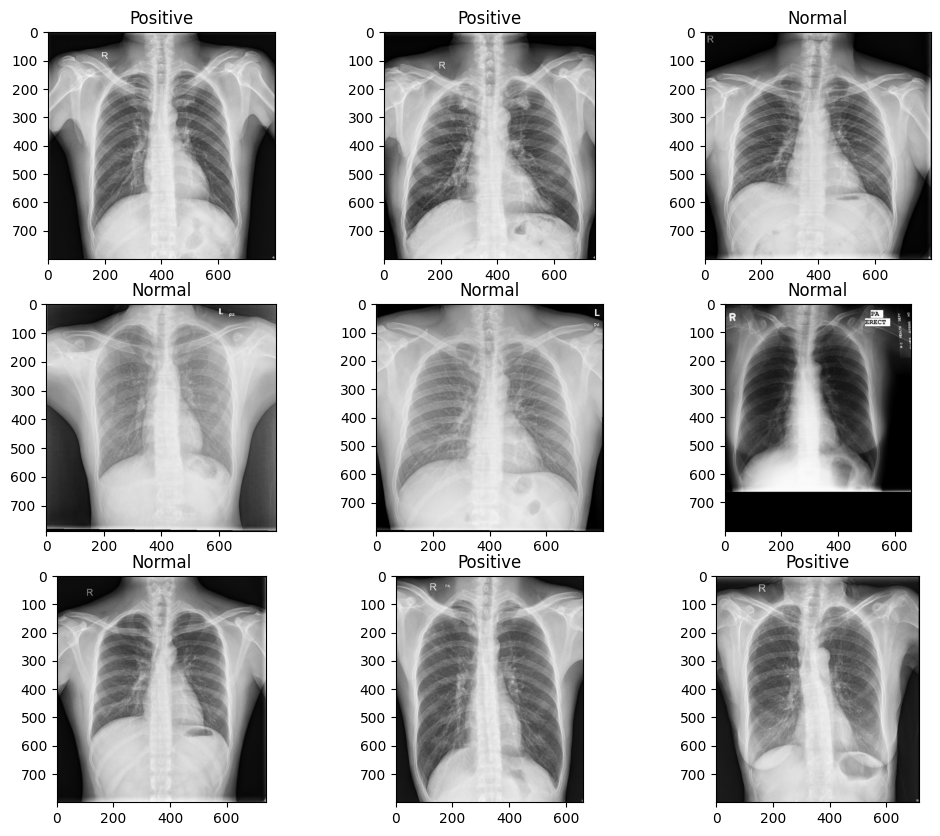

In [10]:
#visualizing 9 random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

In [11]:
#spliting our training data into train and validation set in  ratio 80%, 20%
df_train = train[:575:]
df_val = train[575:]
print(df_train.LABEL.value_counts())
print(df_val.LABEL.value_counts())

LABEL
Normal      295
Positive    280
Name: count, dtype: int64
LABEL
Positive    73
Normal      70
Name: count, dtype: int64


In [12]:
#data generators
batch_size = 32
image_size = (224, 224)
learning_rate = 0.0001

train_steps = np.ceil(len(df_train) / batch_size)
val_steps = np.ceil(len(df_val) / batch_size )

classes = train.LABEL.unique().tolist()

# carrying out data auguemnation processes
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range=10,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   channel_shift_range=10
                                   )


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

#implementing
train_ds = train_datagen.flow_from_dataframe(df_train,x_col='filepath', y_col='LABEL',
                                             target_size=image_size,
                                             classes=classes,
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             shuffle=True, seed=SEED)

val_ds = val_datagen.flow_from_dataframe(df_val,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,
                                        classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False, seed=SEED)

test_ds = val_datagen.flow_from_dataframe(test, x_col='filepath',target_size=image_size,
                                          class_mode=None,
                                          shuffle=False,
                                          batch_size=batch_size)
#set shuffle=False for test dataset not be shuffled

Found 575 validated image filenames belonging to 2 classes.
Found 143 validated image filenames belonging to 2 classes.
Found 82 validated image filenames.


### 4. Model building

In [13]:
#using transfer learning from Inceptwionv3

def BuildModel (pretrained=InceptionV3):
    pre_trained_model = pretrained(include_top=False, weights='imagenet', input_shape=(224, 224,3)) # using include_top=False to remove the last layer
    for layer in pre_trained_model.layers:
        layer.trainable = False   #freezing the trainable layers

    last_desired_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_desired_layer.output
    x = layers.Flatten()(last_output)
    # Addding a fully connected layer with 1024 hidden units and ReLU activation
    x = layers.Dense(1024, activation = 'relu')(x)
    # Adding a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    # Adding a final sigmoid layer for classification
    x = layers.Dense(2, activation = 'sigmoid', name="output" )(x)

    # Creating the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)

    # Compiling the model
    # model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['AUC'])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])

    return model

In [14]:
model = BuildModel()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 122,224,546 (466.25 MB)

 Trainable params: 113,249,282 (432.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [16]:
#generating callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join("/content/drive/MyDrive/zindi_Tuberculosis_Classification/", f"tb_model.keras", )
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss',mode='auto', verbose=1, save_best_only=True,)

In [22]:
#fitting the  model
history = model.fit(train_ds, epochs=10,steps_per_epoch=int(train_steps), callbacks=[earlystop, checkpoint], # Cast train_steps to an integer
                    verbose=1, shuffle=False,validation_data=(val_ds), validation_steps= int(val_steps)) # Cast val_steps to an integer

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - AUC: 0.7346 - loss: 0.6341
Epoch 1: val_loss did not improve from 0.56749
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - AUC: 0.7352 - loss: 0.6339 - val_AUC: 0.6991 - val_loss: 0.7069
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - AUC: 0.7579 - loss: 0.6191
Epoch 3: val_loss did not improve from 0.56749
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 838ms/step - AUC: 0.7572 - loss: 0.6190 - val_AUC: 0.7255 - val_loss: 0.6213
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - AUC: 0.7325 - loss: 0.6228
Epoch 5: val_loss did not improve from 0.56749
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 833ms/step - AUC: 0.7340 - loss: 0.6213 - val_AUC: 0.7593 - val_loss: 0.5708
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - AUC: 0.7626 - loss: 0.5967
Epoch 7: val_loss did not improve from 0.56749
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 847ms/step - AUC: 0.7625 - loss: 0.5967 - val_AUC: 0.7255 - val_loss: 0.6196
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [26]:
#getting AUC value
y_pred = model.predict(val_ds, verbose=1)[:, 1]
fpr, tpr, thresholds = roc_curve(val_ds.classes, y_pred)
auc_value = auc(fpr, tpr)
auc_value

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step


0.711545988258317

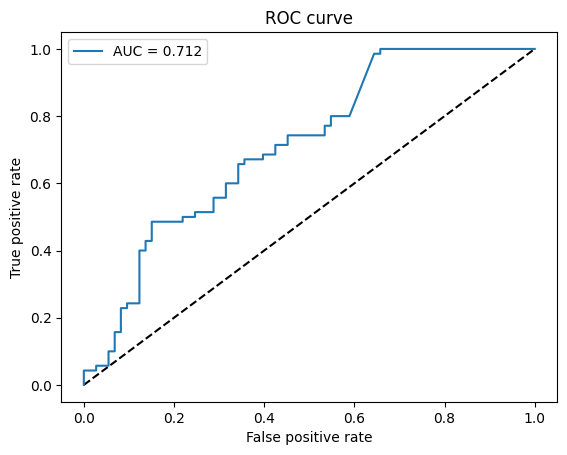

In [29]:
## plotting the AUC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_value))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 5. Submission

In [30]:
#making predictions on test data
predictions = model.predict(test_ds)[:, 1]

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 11s/step


In [31]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['LABEL'] = predictions

In [32]:
submission

,ID,LABEL
0,GTWSHFYQ,0.878589
1,QTFSSMGD,0.893282
2,TBLBHSYT,0.942598
3,ZKETEOFG,0.532504
4,GKTPBGZP,0.816565
5,KHIMVBMD,0.166942
6,KUTPOASE,0.517617
7,NVCFDCZE,0.560387
8,CHDDLHBE,0.499757
9,HIJQIQJT,0.754891


In [33]:
submission.to_csv('starter1.csv', index=False)

In [34]:
# getting the path where the model will be saved
model_save_path = "/content/drive/MyDrive/zindi_Tuberculosis_Classification/tb_model.keras"

#new_tb_model
# Saving the model
model.save(model_save_path)

testing the model prediction on a single image

In [35]:
from tensorflow.keras.models import load_model
from tensorflow import keras

# getting the path where the model is saved
model_path = "/content/drive/MyDrive/zindi_Tuberculosis_Classification/tb_model.keras"

# Loadong the model
loaded_model = keras.models.load_model(model_path)


In [37]:
#importing the neccessary library
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# preprocessing the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


In [38]:
# getting the image from drive
image_path = "/content/drive/MyDrive/GTWSHFYQ.png"

# Preprocessing the image
preprocessed_img = preprocess_image(image_path)

# Making prediction
predictions = model.predict(preprocessed_img)

# Getting the predicted class and confidence
predicted_class = np.argmax(predictions[0])  # Index of the highest probability
confidence = np.max(predictions[0])  # Confidence level (probability of the predicted class)

# Mapping the predicted class index to the labels
class_labels = ['Normal', 'Positive']
predicted_label = class_labels[predicted_class]

print(f"Prediction: {predicted_label}, Confidence: {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction: Positive, Confidence: 0.8786
